# Federated Hierarchical Linear Regression
Here we will demonstrate the utility of federated hierarchical linear regression approach for solving
hierarchical linear regression.

We will use [OSIC Pulmonary Fibrosis Progression](https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression) competition, hosted at Kaggle.

## 1. Understanding the task
Pulmonary fibrosis is a disorder with no known cause and no known cure, created by scarring of the lungs. In this competition, we were asked to predict a patient’s severity of decline in lung function. Lung function is assessed based on output from a spirometer, which measures the forced vital capacity (FVC), i.e. the volume of air exhaled.

In medical applications, it is useful to **evaluate a model's confidence in its decisions**. Accordingly, the metric used to rank the teams was designed to reflect **both the accuracy and certainty of each prediction**. It's a modified version of the Laplace Log Likelihood (more details on that later).

Let's explore the data and see what's that all about:

In [1]:
import numpyro
numpyro.set_platform('cpu')

In [2]:
import optax
import numpyro.distributions as dist
import pandas as pd
import numpy as np
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt

from jax import random, vmap
from numpyro.infer import MCMC, NUTS, SVI, Predictive, TraceGraph_ELBO

In [3]:
train = pd.read_csv(
    "https://gist.githubusercontent.com/ucals/"
    "2cf9d101992cb1b78c2cdd6e3bac6a4b/raw/"
    "43034c39052dcf97d4b894d2ec1bc3f90f3623d9/"
    "osic_pulmonary_fibrosis.csv"
)

# separate data on subjects 
def make_dictionary(dataset, patient_ids):
    dicts = {}
    for n, id in enumerate(patient_ids):
        df = dataset.loc[dataset.Patient.isin([id])]
        labels = {
            'Age': df.Age,
            'Sex': df.Sex,
            'SmokingStatus': df.SmokingStatus 
        }

        dicts[id] = {'target': df.FVC.values, 'covariates': df.Weeks, 'labels': labels}

    return dicts

fed_data = make_dictionary(train, train.Patient.unique())

train

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker
...,...,...,...,...,...,...,...
1544,ID00426637202313170790466,13,2712,66.594637,73,Male,Never smoked
1545,ID00426637202313170790466,19,2978,73.126412,73,Male,Never smoked
1546,ID00426637202313170790466,31,2908,71.407524,73,Male,Never smoked
1547,ID00426637202313170790466,43,2975,73.052745,73,Male,Never smoked


In the dataset, we were provided with a baseline chest CT scan and associated clinical information for a set of patients. A patient has an image acquired at time Week = 0 and has numerous follow up visits over the course of approximately 1-2 years, at which time their FVC is measured. For this tutorial, I will use only the Patient ID, the weeks and the FVC measurements, discarding all the rest. Using only these columns enabled our team to achieve a competitive score, which shows the power of Bayesian hierarchical linear regression models especially when gauging uncertainty is an important part of the problem.

Since this is real medical data, the relative timing of FVC measurements varies widely, as shown in the 3 sample patients below:

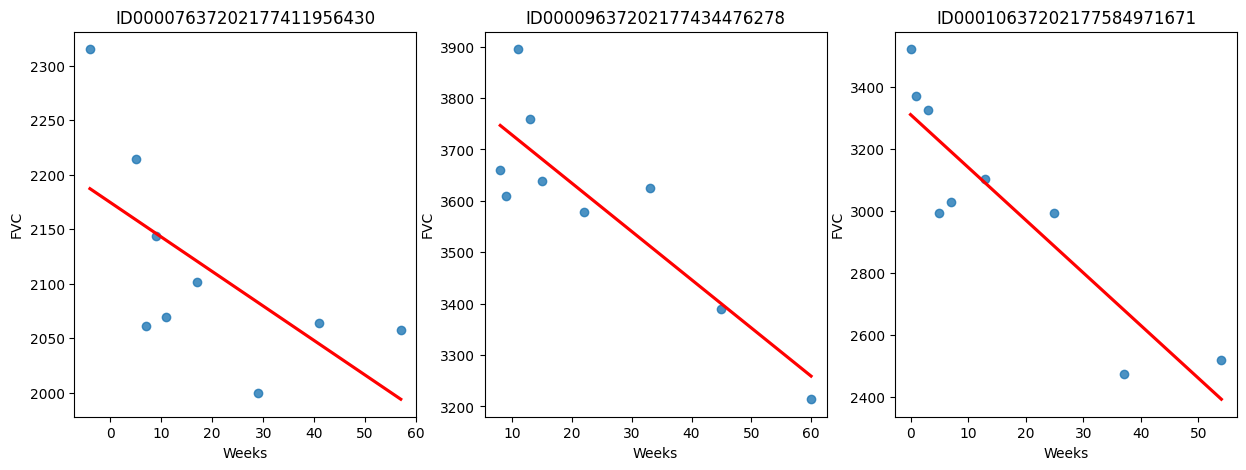

In [4]:
def chart_patient(patient_id, ax):
    data = train[train["Patient"] == patient_id]
    x = data["Weeks"]
    y = data["FVC"]
    ax.set_title(patient_id)
    sns.regplot(x=x, y=y, ax=ax, ci=None, line_kws={"color": "red"})


f, axes = plt.subplots(1, 3, figsize=(15, 5))
chart_patient("ID00007637202177411956430", axes[0])
chart_patient("ID00009637202177434476278", axes[1])
chart_patient("ID00010637202177584971671", axes[2])

On average, each of the 176 provided patients made 9 visits, when FVC was measured. The visits happened in specific weeks in the [-12, 133] interval. The decline in lung capacity is very clear. We see, though, they are very different from patient to patient.

We were are asked to predict every patient's FVC measurement for every possible week in the [-12, 133] interval, and the confidence for each prediction. In other words: we were asked fill a matrix like the one below, and provide a confidence score for each prediction:

<img src="https://i.ibb.co/0Z9kW8H/matrix-completion.jpg" alt="drawing" width="600"/>

## 2. Modelling: Bayesian Hierarchical Linear Regression with Partial Pooling
The simplest possible linear regression, not hierarchical, would assume all FVC decline curves have the same $\alpha$ and $\beta$. That's the **pooled model**. In the other extreme, we could assume a model where each patient has a personalized FVC decline curve, and **these curves are completely unrelated**. That's the **unpooled model**, where each patient has completely separate regressions.

Here, I'll use the middle ground: **Partial pooling**. Specifically, I'll assume that while $\alpha$'s and $\beta$'s are different for each patient as in the unpooled case, **the coefficients all share similarity**. We can model this by assuming that each individual coefficient comes from a common group distribution. The image below represents this model graphically:

<img src="https://i.ibb.co/H7NgBfR/Artboard-2-2x-100.jpg" alt="drawing" width="600"/>

Mathematically, the model is described by the following equations:

\begin{align}
\mu_{\alpha} &\sim \mathcal{N}(0, 500) \\
\sigma_{\alpha}^2 &\sim \Gamma^{-1}(2, 10^5) \\
\mu_{\beta} &\sim \mathcal{N}(0, 3) \\
\sigma_{\beta}^2 &\sim \Gamma^{-1}(2, 5) \\
u &\sim \Gamma^{-1}\left(\frac{1}{2}, 10^4 \right) \\
\alpha_i &\sim \mathcal{N}(\mu_{\alpha}, \sigma_{\alpha}) \\
\beta_i &\sim \mathcal{N}(\mu_{\beta}, \sigma_{\beta}) \\
\sigma_i &\sim \Gamma^{-1}\left( \frac{1}{2}, u \right) \\
FVC_{ij} &\sim \mathcal{N}(\alpha_i + t \beta_i, \sigma_i)
\end{align}

where *t* is the time in weeks. Those are very uninformative priors, but that's ok: our model will converge!

Implementing this model in NumPyro is pretty straightforward:

In [5]:
from fedbmr.feds import GenerativeModel, GlobalPrior
from fedbmr.utils import log_factor

prior_specs = {
    "μ_α": dist.Normal,
    "u_α": dist.Gamma,
    "μ_β": dist.Normal,
    "u_β": dist.Gamma,
    "u":  dist.Gamma
}

default_param_vals = {
    "μ_α": dict(loc=0.0, scale=500.0),
    "u_α": dict(concentration=2., rate=1.),
    "μ_β": dict(loc=0.0, scale=3.0),
    "u_β": dict(concentration=2., rate=1.),
    "u":  dict(concentration=.5, rate=1.)
}

global_prior = GlobalPrior(prior_specs, default_param_vals)
global_prior();

In [6]:
from numpyro.handlers import reparam
from numpyro.infer.reparam import LocScaleReparam
from fedbmr.feds import GenerativeModel

def global_model(prior, covariates, obs=None, **kwargs):
    output_dict = {}
    for name, p in prior.items():
        output_dict[name] = numpyro.sample(name, p.dist)
        # numpyro.factor(name + '.divide', -log_factor(p.dist, p.approx_params, output_dict[name]))

    output_dict["σ_α"] = numpyro.deterministic("σ_α", jnp.sqrt(1e3 / output_dict["u_α"]))
    output_dict["σ_β"] = numpyro.deterministic("σ_β", jnp.sqrt(1 / output_dict["u_β"]))

    output_dict["covariates"] = covariates
    output_dict["obs"] = obs

    output_dict.update(kwargs)

    return output_dict

def local_model(input_dict):
    μ_α = input_dict["μ_α"]
    μ_β = input_dict["μ_β"]
    σ_α = input_dict["σ_α"] 
    σ_β = input_dict["σ_β"]
    u = input_dict["u"]

    Weeks = input_dict["covariates"]
    FVC_obs = input_dict["obs"]
    mask = input_dict.pop("mask", None)
    subsample_size = input_dict.pop("subsample_size", None)

    n_data, n_patients = Weeks.shape
    with numpyro.plate("patients", n_patients, subsample_size=subsample_size):

        covariates = numpyro.subsample(Weeks, event_dim=0)
        obs = numpyro.subsample(FVC_obs, event_dim=0) if FVC_obs is not None else None
        m = numpyro.subsample(mask, event_dim=0) if mask is not None else True

        v = numpyro.sample("v", dist.Gamma(.5, 1.))
        σ = numpyro.deterministic("σ", jnp.sqrt(1e4 * u / v))
        α = numpyro.sample("α", dist.Normal(μ_α, σ * σ_α))
        β = numpyro.sample("β", dist.Normal(μ_β, σ * σ_β))
        
        loc = α + β * covariates
        with numpyro.plate("data", n_data):
            numpyro.sample("obs", dist.Normal(loc, σ).mask(m), obs=obs)
    
model = GenerativeModel(global_prior(), global_model, local_model)

reparam_config = {
    "α": LocScaleReparam(0),
    "β": LocScaleReparam(0)
}

reparam_model = reparam(model, config=reparam_config)

In [7]:
from fedbmr.feds import Posterior

def normal_post(name, shape=(), idx=None):
    loc = numpyro.param(
        name + '.loc', 
        lambda rng_key: dist.Uniform(-2, 2)(rng_key=rng_key,sample_shape=shape)
    )
    scale = numpyro.param(name + '.scale', jnp.ones(shape)/10, constraint=dist.constraints.positive)

    if idx is not None:
        return dist.Normal(loc[idx], scale[idx])
    else:
        return dist.Normal(loc, scale)

def lognormal_post(name, shape=(), idx=None):
    loc = numpyro.param(
        name + '.loc', 
        lambda rng_key: dist.Uniform(-2, 2)(rng_key=rng_key, sample_shape=shape)
    )
    scale = numpyro.param(name + '.scale', jnp.ones(shape)/10, constraint=dist.constraints.positive)

    if idx is not None:
        site_fn = dist.Normal(loc[idx], scale[idx])
    else:
        site_fn = dist.Normal(loc, scale)

    transform = biject_to(dist.constraints.positive)
    return dist.TransformedDistribution(site_fn, transform)

def gamma_post(name, shape=(), idx=None):

    a = numpyro.param(
        name + '.concentration', 
        lambda rng_key: dist.Uniform(2, 10)(rng_key=rng_key, sample_shape=shape)
    )
    
    b = numpyro.param(name + '.rate', jnp.ones(shape), constraint=dist.constraints.positive)

    if idx is not None:
        return dist.Gamma(a[idx], b[idx])
    else:
        return dist.Gamma(a, b)

def exact_bayes_reg(y, X, a_0=.5, b_0=1., mask=None, Λ_0=None, μ_0=None):
    if jnp.ndim(X) > 1:
        _X = jnp.pad(X, ((0, 0), (1, 0)), constant_values=1.)
    else:
        _X = jnp.pad(jnp.expand_dims(X, -1), ((0, 0), (1, 0)), constant_values=1.)

    _X = jnp.expand_dims(mask, -1) * _X if mask is not None else _X
    Λ_0 = jnp.identity(_X.shape[-1]) if Λ_0 is None else Λ_0
    μ_0 = jnp.zeros(_X.shape[-1]) if μ_0 is None else μ_0

    Λₙ = Λ_0 + _X.T @ _X
    Σₙ = jnp.linalg.solve(Λₙ, jnp.identity(_X.shape[-1]))

    μₙ = Σₙ @ (_X.T @ y + Λ_0 @ μ_0)

    aₙ = a_0 + mask.sum()/2 if mask is not None else a_0 + _X.shape[0]/2.
    bₙ = b_0 + (jnp.inner(y, y) + μ_0 @ Λ_0 @ μ_0 - μₙ @ Λₙ @ μₙ )/2

    return μₙ, Σₙ, aₙ, bₙ

def global_posterior(covariates, obs=None, **kwargs):

    mask = kwargs.pop("mask", None)
    subsample_size = kwargs.pop("subsample_size", None)

    μ_α = numpyro.sample("μ_α", normal_post("μ_α"))
    u_α = numpyro.sample('u_α', gamma_post('u_α'))
    σ_α_sqr_inv = u_α / 1e3

    μ_β = numpyro.sample("μ_β", normal_post("μ_β"))
    u_β = numpyro.sample('u_β', gamma_post('u_β'))
    σ_β_sqr_inv = u_β

    Λ_0 = jnp.diag(jnp.array([σ_α_sqr_inv, σ_β_sqr_inv]))
    μ_0 = jnp.array([μ_α, μ_β])

    u = numpyro.sample('u', gamma_post('u'))
    b_0 = 1e4 * u

    output_dict = {
        'Λ_0': Λ_0,
        'μ_0': μ_0,
        'b_0': b_0,
        'covariates': covariates,
        'obs': obs,
        'mask': mask,
        'subsample_size': subsample_size
    }

    return output_dict

def local_posterior(input_dict):
    Λ_0 = input_dict['Λ_0'] 
    μ_0 = input_dict['μ_0'] 
    b_0 = input_dict['b_0']

    covariates = input_dict['covariates']
    obs = input_dict['obs']
    mask = input_dict['mask']
    subsample_size = input_dict['subsample_size']

    _, n_patients = covariates.shape
    exact_b = lambda x, y, z: exact_bayes_reg(x, y, mask=z, Λ_0=Λ_0, μ_0=μ_0, b_0=b_0)

    with numpyro.plate("patients", n_patients, subsample_size=subsample_size):
        X = numpyro.subsample(covariates, event_dim=0)
        y = numpyro.subsample(obs, event_dim=0) if obs is not None else None
        msk = numpyro.subsample(mask, event_dim=0) if mask is not None else None

        μₙ, Σₙ, aₙ, bₙ = vmap(exact_b)(y.T, X.T, msk.T)
        
        v = numpyro.sample("v", dist.Gamma(aₙ, bₙ / b_0))
        σ_sqr = b_0/v

        cov_mat = jnp.expand_dims(σ_sqr, (-1, -2)) * Σₙ
        z = numpyro.sample('z', dist.MultivariateNormal(μₙ, covariance_matrix=cov_mat), infer={"is_auxiliary": True})

        numpyro.sample('α', dist.Delta(z[:, 0]))
        numpyro.sample('β', dist.Delta(z[:, 1]))


post = Posterior(global_posterior, local_posterior)

## 3. Fitting the model
A great achievement of Probabilistic Programming Languages such as NumPyro is to decouple model specification and inference. After specifying my generative model, with priors, condition statements and data likelihood, I can leave the hard work to NumPyro's inference engine. 

Calling it requires just a few lines. Before we do it, let's add a numerical Patient ID for each patient code. That can be easily done with scikit-learn's LabelEncoder:

In [8]:
weeks = jnp.arange(train.Weeks.min(), train.Weeks.max() + 1)
df = pd.DataFrame(index=weeks, columns=range(len(fed_data)))

weeks = jnp.broadcast_to(weeks[:, None], (len(weeks), len(fed_data)))
weeks.shape

patient_encoder = dict([(idx, i) for i, idx in enumerate(train["Patient"].unique())])
train["patient_code"] = np.array([patient_encoder[idx] for idx in train["Patient"].values])

for id in fed_data:
    df.loc[fed_data[id]['covariates'].values, patient_encoder[id]] = fed_data[id]['target']

FVC_obs = df.astype(float).values
mask = ~jnp.isnan(FVC_obs)
FVC_obs = jnp.nan_to_num(FVC_obs)

rng_key = random.PRNGKey(0)

Now, calling NumPyro's inference engine:

In [ ]:
data = {
    'covariates': weeks,
    'obs': FVC_obs,
    'mask': mask
}

nuts_kernel = NUTS(reparam_model)

mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=2000)
mcmc.run(rng_key, **data)

posterior_samples = mcmc.get_samples()

# Stochastic variational inference



In [10]:
data = {
    'covariates': weeks,
    'obs': FVC_obs,
    'mask': mask
}

optim = optax.adabelief(learning_rate=1e-2)
loss = TraceGraph_ELBO(num_particles=10)
svi = SVI(model, post, optim, loss)

rng_key, _rng_key = random.split(rng_key)
svi_res = svi.run(_rng_key, 30_000, progress_bar=True, **data)

pred = Predictive(post, params=svi_res.params, num_samples=1000)
rng_key, _rng_key = random.split(rng_key)
svi_samples1 = pred(_rng_key, **data)

pred = Predictive(model, posterior_samples=svi_samples1)
rng_key, _rng_key = random.split(rng_key)
svi_samples1.update(pred(_rng_key, **data))

100%|██████████| 30000/30000 [01:44<00:00, 286.73it/s, init loss: 11396.2627, avg. loss [28501-30000]: 10439.8594]


In [14]:
data = {
    'covariates': weeks,
    'obs': FVC_obs,
    'mask': mask
}

optim = optax.adabelief(learning_rate=1e-2)
loss = TraceGraph_ELBO(num_particles=10)
svi = SVI(model, post, optim, loss)

rng_key, _rng_key = random.split(rng_key)
svi_res = svi.run(_rng_key, 50_000, subsample_size=20, **data)

pred = Predictive(post, params=svi_res.params, num_samples=1000)
rng_key, _rng_key = random.split(rng_key)
svi_samples2 = pred(_rng_key, **data)

pred = Predictive(model, posterior_samples=svi_samples2)
rng_key, _rng_key = random.split(rng_key)
svi_samples2.update(pred(_rng_key, **data))

100%|██████████| 50000/50000 [00:48<00:00, 1039.15it/s, init loss: 11242.7129, avg. loss [47501-50000]: 10437.5557]


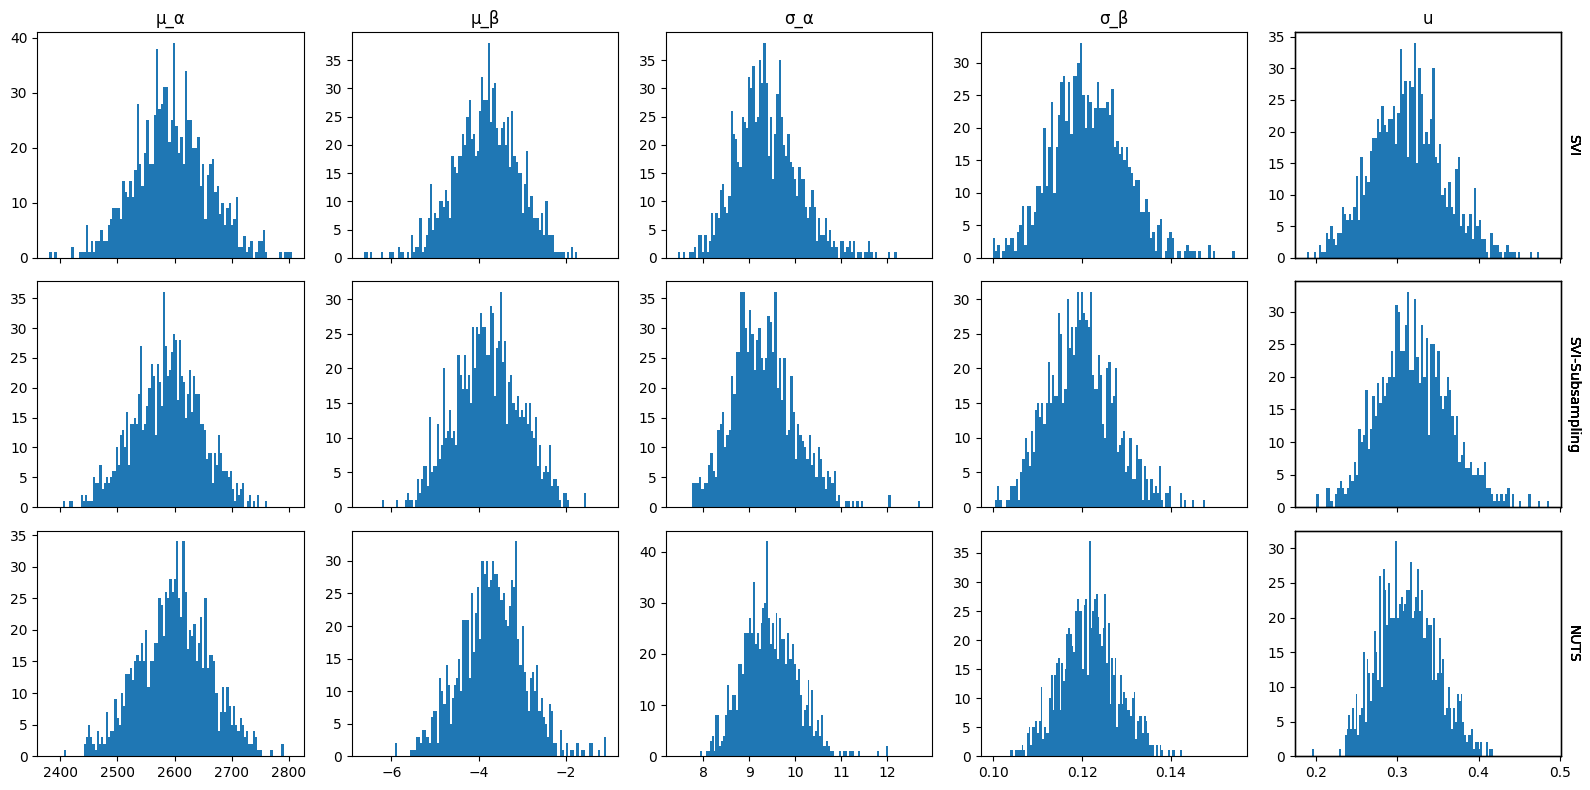

In [12]:
fig, axes = plt.subplots(3, 5, figsize=(16, 8), sharex='col')
for i, name in enumerate(['μ_α', 'μ_β', 'σ_α', 'σ_β', 'u']):
    axes[0, i].hist(svi_samples1[name], bins=100);
    twin = axes[0, -1].twinx()
    twin.set_ylabel('SVI', rotation=-90, labelpad=10)
    twin.set_yticks([])

    axes[1, i].hist(svi_samples2[name], bins=100);
    twin = axes[1, -1].twinx()
    twin.set_ylabel('SVI-Subsampling', rotation=-90, labelpad=10)
    twin.set_yticks([])

    axes[2, i].hist(posterior_samples[name], bins=100);
    twin = axes[2, -1].twinx()
    twin.set_ylabel('NUTS', rotation=-90, labelpad=10)
    twin.set_yticks([])
    
    axes[0, i].set_title(name)

fig.tight_layout()

# Federated variational inference

In [28]:
from fedbmr.feds import InfFed

rng_key = random.PRNGKey(777)

# create clients
num_clients = 100
num_patients = 2
federation = {}
for i in range(num_clients):
    select_patients = np.random.choice(len(fed_data), size=(num_patients,), replace=False)

    data = {
        'covariates': weeks[:, select_patients].astype(jnp.float32),
        'obs': FVC_obs[..., select_patients].astype(jnp.float32), 
        'mask': mask[..., select_patients]
    }

    global_prior = GlobalPrior(prior_specs, default_param_vals)
    gm = GenerativeModel(global_prior(), global_model, local_model)
    post = Posterior(global_posterior, local_posterior)
    inf_fed = InfFed(global_prior, gm, post)

    federation[i] = {'data': data, 'client': inf_fed}

In [29]:
# sequential algorithm
from tqdm.auto import tqdm
import jax.tree_util as jtu
from functools import partial

num_epochs = 1
gp = federation[0]['client'].global_prior()
posteriors = []
for e in range(num_epochs):
    for n in tqdm(range(len(federation))):
        rng_key, _rng_key = random.split(rng_key)
        federation[n]['client'].recieve_prior(gp)
        data = federation[n]['data']
        federation[n]['client'].inference(_rng_key, data, num_steps=30_000, opt_kwargs={'learning_rate': 1e-2})
        gp = federation[n]['client'].send_posterior()
        posteriors.append( gp )

  0%|          | 0/100 [00:00<?, ?it/s]

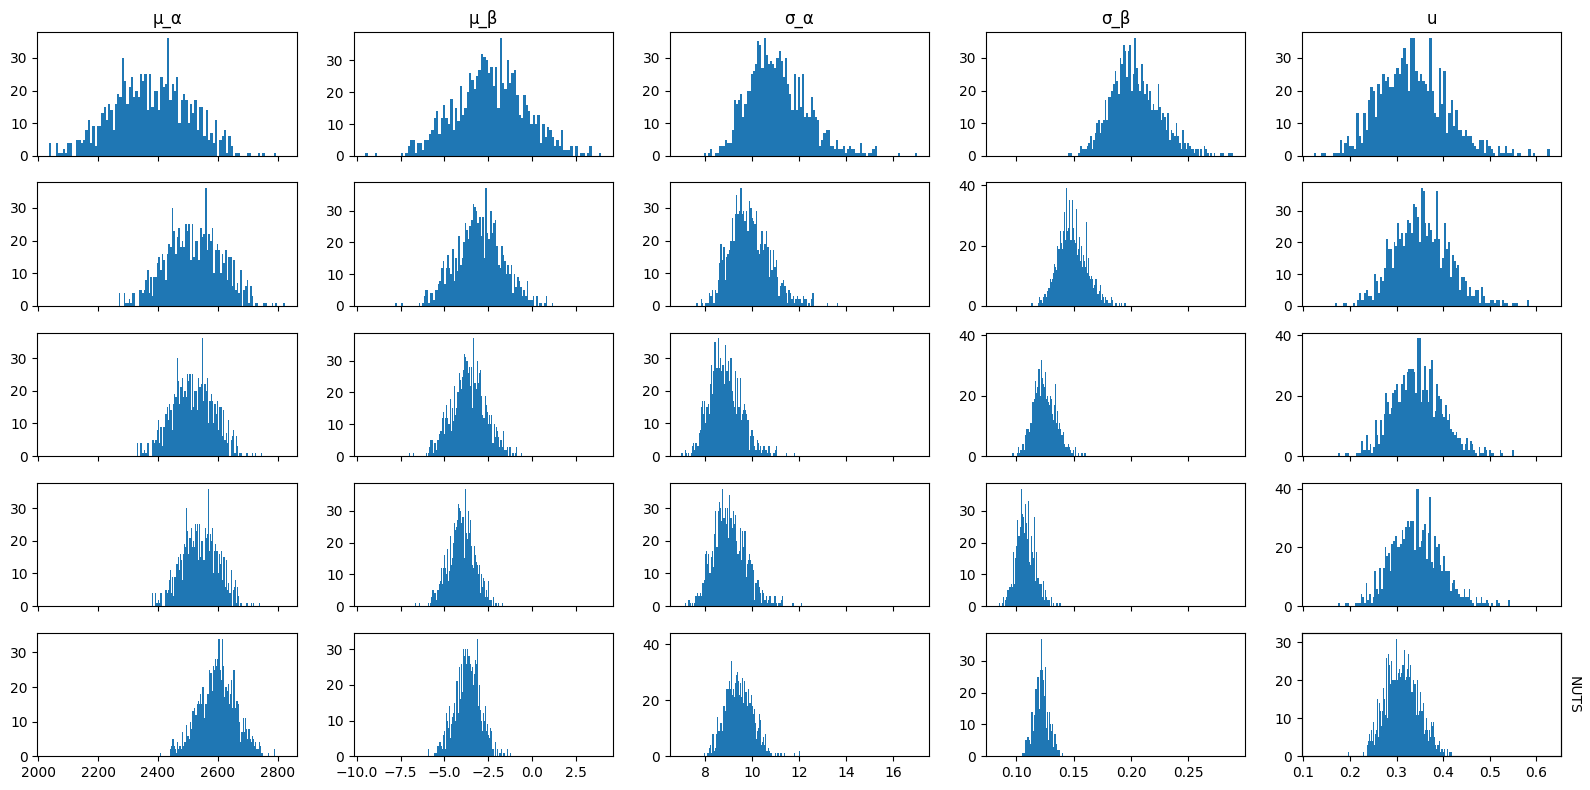

In [24]:
m = len(federation)
fig, axes = plt.subplots(5, 5, figsize=(16, 8), sharex='col')

for i, idx in enumerate([0, 33, 66, 99]): 
    gm = GenerativeModel(posteriors[idx], global_model, local_model)
    fed_smpl = Predictive(gm, num_samples=1000)(rng_key, **federation[idx]['data'])

    for j, name in enumerate(['μ_α', 'μ_β', 'σ_α', 'σ_β', 'u']):
        axes[i, j].hist(fed_smpl[name], bins=100);
        if i == 0:
            axes[0, j].set_title(name)
    
    twin = axes[i, -1].twinx()
    twin.set_ylabel(f'Iteration {idx}', rotation=-90, labelpad=10)
    twin.set_yticks([])

for j, name in enumerate(['μ_α', 'μ_β', 'σ_α', 'σ_β', 'u']):
    axes[-1, j].hist(posterior_samples[name], bins=100)

twin = axes[-1, -1].twinx()
twin.set_ylabel('NUTS', rotation=-90, labelpad=10)
twin.set_yticks([])

fig.tight_layout()

Looks like our model learned personalized alphas and betas for each patient!

### 4.2. Visualizing FVC decline curves for some patients
Now, let's visually inspect FVC decline curves predicted by our model. We will completely fill in the FVC table, predicting all missing values. The first step is to create a table to fill:

In [ ]:
def create_prediction_template(unique_patient_df, weeks_series):
    unique_patient_df["_temp"] = True
    weeks = pd.DataFrame(weeks_series, columns=["Weeks"])
    weeks["_temp"] = True
    return unique_patient_df.merge(weeks, on="_temp").drop(["_temp"], axis=1)

In [ ]:
patients = train[["Patient", "patient_code"]].drop_duplicates()

start_week_number = -12
end_week_number = 134
weeks = jnp.arange(start_week_number, end_week_number)
weeks = jnp.broadcast_to(weeks[:, None], (len(weeks), len(fed_data)))

predict_weeks = pd.Series(np.arange(start_week_number, end_week_number))
pred_template = create_prediction_template(patients, predict_weeks)

weeks.shape

(146, 176)

Predicting the missing values in the FVC table and confidence (sigma) for each value becomes really easy:

In [ ]:
def generate_predictions(model, posterior_samples):
    predictive = Predictive(model, posterior_samples=posterior_samples, return_sites=["σ", "obs"])
    samples_predictive = predictive(random.PRNGKey(0), weeks)

    df_fvc = pd.DataFrame(samples_predictive['obs'].mean(0), index=predict_weeks)
    df_sigma = pd.DataFrame(samples_predictive['obs'].std(0), index=predict_weeks)
    df_inf = df_fvc - df_sigma
    df_sup = df_fvc + df_sigma

    df = pred_template
    for _df, name in zip([df_fvc, df_sigma, df_inf, df_sup], ['FVC_pred', 'sigma', "FVC_inf", "FVC_sup"]):
        df = df.merge(_df.reset_index(names='Weeks').melt(id_vars='Weeks', var_name='patient_code', value_name=name), on=["patient_code",	"Weeks"])

    df = pd.merge(df, train[["Patient", "Weeks", "FVC"]], how='left', on=["Patient", "Weeks"])
    df = df.rename(columns={"FVC": "FVC_true"})
    return df

df1 = generate_predictions(reparam_model, posterior_samples)
svi_samples1.pop('obs')
df2 = generate_predictions(model, svi_samples1)

TypeError: global_model() missing 1 required positional argument: 'covariates'

Let's now put the predictions together with the true values, to visualize them:

Finally, let's see our predictions for 3 patients:

In [ ]:
def chart_patient_with_predictions(df, patient_id, ax):
    data = df[df["Patient"] == patient_id]
    x = data["Weeks"]
    ax.set_title(patient_id)
    ax.plot(x, data["FVC_true"], "o")
    ax.plot(x, data["FVC_pred"])
    ax = sns.regplot(x=x, y=data["FVC_true"], ax=ax, ci=None, line_kws={"color": "red"})
    ax.fill_between(x, data["FVC_inf"], data["FVC_sup"], alpha=0.5, color="#ffcd3c")
    ax.set_ylabel("FVC")

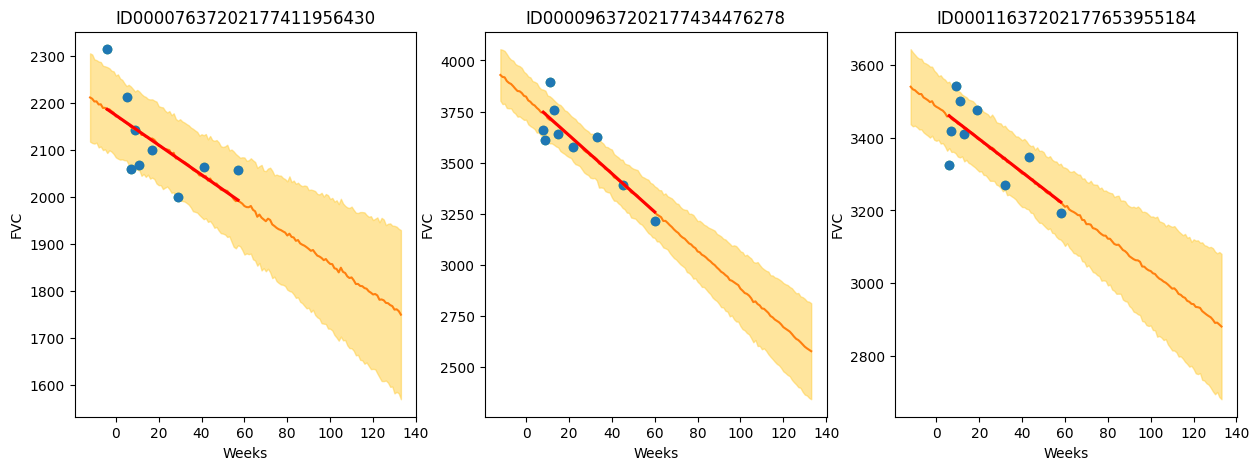

In [ ]:
f, axes = plt.subplots(1, 3, figsize=(15, 5))
chart_patient_with_predictions(df1, "ID00007637202177411956430", axes[0])
chart_patient_with_predictions(df1, "ID00009637202177434476278", axes[1])
chart_patient_with_predictions(df1, "ID00011637202177653955184", axes[2])

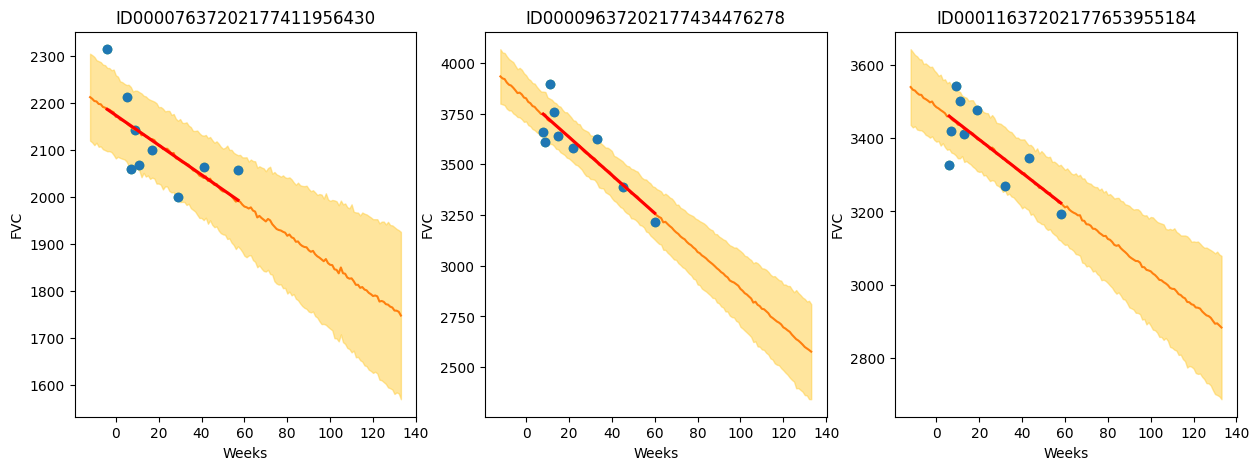

In [ ]:
f, axes = plt.subplots(1, 3, figsize=(15, 5))
chart_patient_with_predictions(df2, "ID00007637202177411956430", axes[0])
chart_patient_with_predictions(df2, "ID00009637202177434476278", axes[1])
chart_patient_with_predictions(df2, "ID00011637202177653955184", axes[2])

The results are exactly what we expected to see! Highlight observations:

- The model adequately learned Bayesian Linear Regressions! The orange line (learned predicted FVC mean) is very inline with the red line (deterministic linear regression). But most important: it learned to predict uncertainty, showed in the light orange region (one sigma above and below the mean FVC line)
- The model predicts a higher uncertainty where the data points are more disperse (1st and 3rd patients). Conversely, where the points are closely grouped together (2nd patient), the model predicts a higher confidence (narrower light orange region)
- Finally, in all patients, we can see that the uncertainty grows as the look more into the future: the light orange region widens as the # of weeks grow!

### 4.3. Computing the modified Laplace Log Likelihood and RMSE

As mentioned earlier, the competition was evaluated on a modified version of the Laplace Log Likelihood. In medical applications, it is useful to evaluate a model's confidence in its decisions. Accordingly, the metric is designed to reflect both the accuracy and certainty of each prediction.

For each true FVC measurement, we predicted both an FVC and a confidence measure (standard deviation $\sigma$). The metric was computed as:

\begin{align}
\sigma_{clipped} &= max(\sigma, 70) \\
\delta &= min(|FVC_{true} - FVC_{pred}|, 1000) \\
metric &= -\dfrac{\sqrt{2}\delta}{\sigma_{clipped}} - \ln(\sqrt{2} \sigma_{clipped})
\end{align}

The error was thresholded at 1000 ml to avoid large errors adversely penalizing results, while the confidence values were clipped at 70 ml to reflect the approximate measurement uncertainty in FVC. The final score was calculated by averaging the metric across all (Patient, Week) pairs. Note that metric values will be negative and higher is better.

Next, we calculate the metric and RMSE:

In [ ]:
def prediciton_metric(df):
    y = df.dropna()
    rmse = ((y["FVC_pred"] - y["FVC_true"]) ** 2).mean() ** (1 / 2)
    print(f"RMSE: {rmse:.1f} ml")

    sigma_c = y["sigma"].values
    sigma_c[sigma_c < 70] = 70
    delta = (y["FVC_pred"] - y["FVC_true"]).abs()
    delta[delta > 1000] = 1000
    lll = -np.sqrt(2) * delta / sigma_c - np.log(np.sqrt(2) * sigma_c)
    print(f"Laplace Log Likelihood: {lll.mean():.4f}")

prediciton_metric(df1)
prediciton_metric(df2)

print('Origina values \n')
print('Origina values from Numpyro\'s example \n RMSE: 122.3 ml \n Laplace Log Likelihood: -6.1406')
print('Smaller RMSE is better, and larger log-likelihood is better')


RMSE: 119.6 ml
Laplace Log Likelihood: -5.9670
RMSE: 119.6 ml
Laplace Log Likelihood: -5.9676
Origina values 

Origina values from Numpyro's example 
 RMSE: 122.3 ml 
 Laplace Log Likelihood: -6.1406
Smaller RMSE is better, and larger log-likelihood is better
